# **MBTPy**
---
model_training


## Intro - overview of the dataset
---

### Data Loading
---

In [2]:
# Importing libraries

import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
import re

from wordcloud import WordCloud
from tqdm import tqdm
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, FunctionTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer

from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC,LinearSVC
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.experimental import enable_hist_gradient_boosting

from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline



c:\Users\toino\anaconda3\envs\MBTPy_env\lib\site-packages\sklearn\experimental\enable_hist_gradient_boosting.py:16: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(
c:\Users\toino\anaconda3\envs\MBTPy_env\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [6]:
# Load data
data=pd.read_csv('../data/raw/mbti_1.csv')
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8675 entries, 0 to 8674
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   type    8675 non-null   object
 1   posts   8675 non-null   object
dtypes: object(2)
memory usage: 135.7+ KB


,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


## Preprocessing
---

### Train-test split

In [7]:
# Stratify split to ensure equal distribution of data
train_data,test_data=train_test_split(data,test_size=0.2,random_state=42,stratify=data.type)
print(train_data.shape)
print(test_data.shape)


### Data Cleaning

Cleaning the text data is an important step as it removes any irrelevant or unnecessary information that might be present in the text data. This includes removing links, special characters, numbers, etc. This is done to make sure that the text data is in a format that can be easily processed by the models.

In [8]:
# Data Cleaning

def clear_text(data):
    data_length=[]
    lemmatizer=WordNetLemmatizer()
    cleaned_text=[]
    for sentence in tqdm(data.posts):
        sentence=sentence.lower()
        
#         removing links from text data
        sentence=re.sub('https?://[^\s<>"]+|www\.[^\s<>"]+',' ',sentence)
    
#         removing other symbols
        sentence=re.sub('[^0-9a-z]',' ',sentence)
    
        
        data_length.append(len(sentence.split()))
        cleaned_text.append(sentence)
    return cleaned_text,data_length


train_data.posts,train_length=clear_text(train_data)


test_data.posts,test_length=clear_text(test_data)



100%|██████████| 1735/1735 [00:00<00:00, 3052.35it/s]


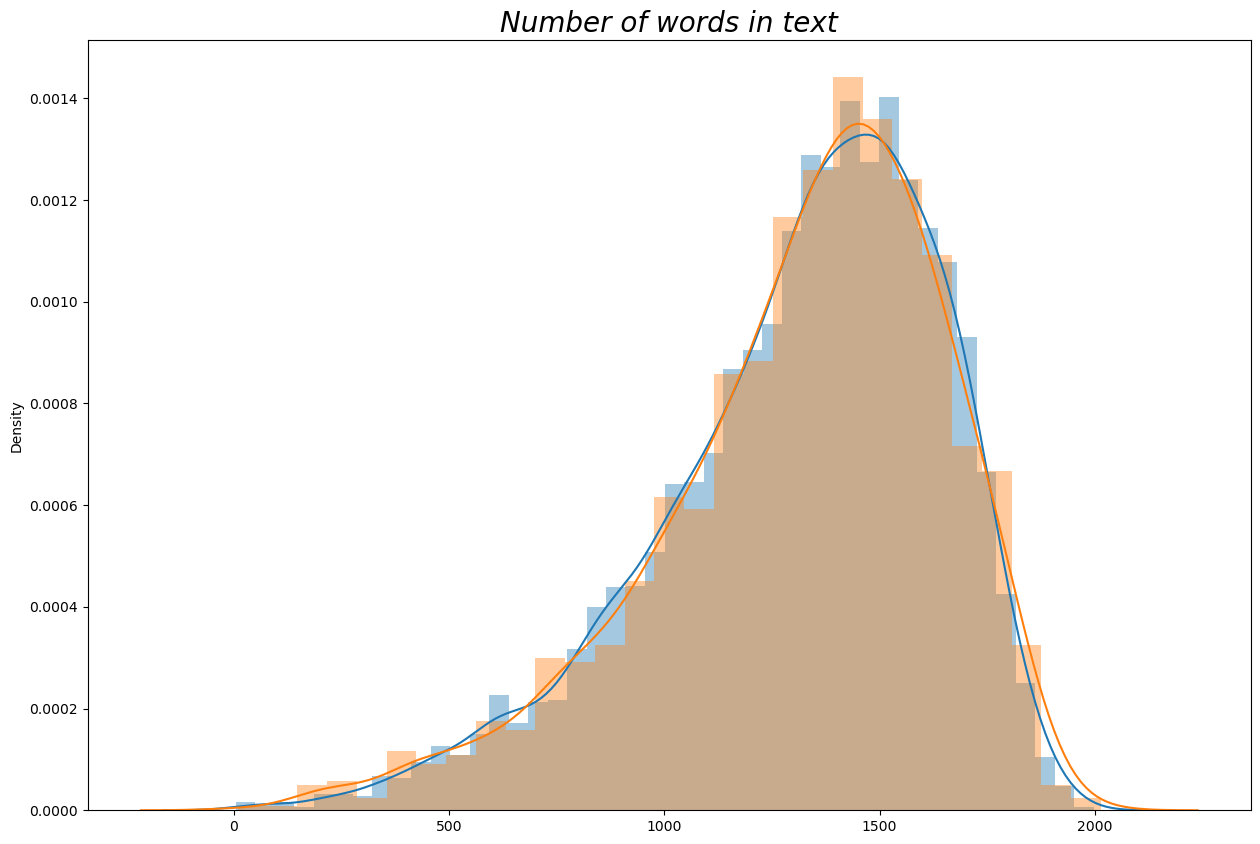

In [9]:
plt.figure(figsize=(15,10))
sns.distplot(train_length,label='train data word length')
sns.distplot(test_length,label='test data word length')
plt.title('Number of words in text',fontdict={'size':20,'style':'italic'})
plt.show()

### Tokenizing (useful???)

Tokenizing the text data is the process of breaking down the text data into individual words or tokens. This is done to convert the text data into a format that can be easily processed by the models.

In [10]:
# Tokenizing

import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

def tokenize_text(text):
    tokens = nltk.word_tokenize(text)
    pos_tags = nltk.pos_tag(tokens)
    return [token for token, pos in pos_tags if pos != 'NNP' and pos != 'NNPS']

# Apply tokenization to the text data
train_data['posts'] = train_data['posts'].apply(tokenize_text)
test_data['posts'] = test_data['posts'].apply(tokenize_text)


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\toino\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\toino\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [11]:
train_data['posts'] = train_data['posts'].apply(lambda x: ' '.join(x))
test_data['posts'] = test_data['posts'].apply(lambda x: ' '.join(x))

### Vectorizing

Vectorizing the text data is the process of converting the tokenized text data into numerical values so that it can be used as input to the models. This is done using techniques like bag-of-words or TF-IDF.

In [12]:
# Vectorizing

class Lemmatizer(object):
    def __init__(self):
        self.lemmatizer = WordNetLemmatizer()
    def __call__(self, sentence):
        return [self.lemmatizer.lemmatize(word) for word in sentence.split() if len(word)>2]


vectorizer=TfidfVectorizer( max_features=5000,stop_words='english',tokenizer=Lemmatizer())
vectorizer.fit(train_data.posts)


train_post=vectorizer.transform(train_data.posts).toarray()
test_post=vectorizer.transform(test_data.posts).toarray()

train_post.shape


(6940, 5000)

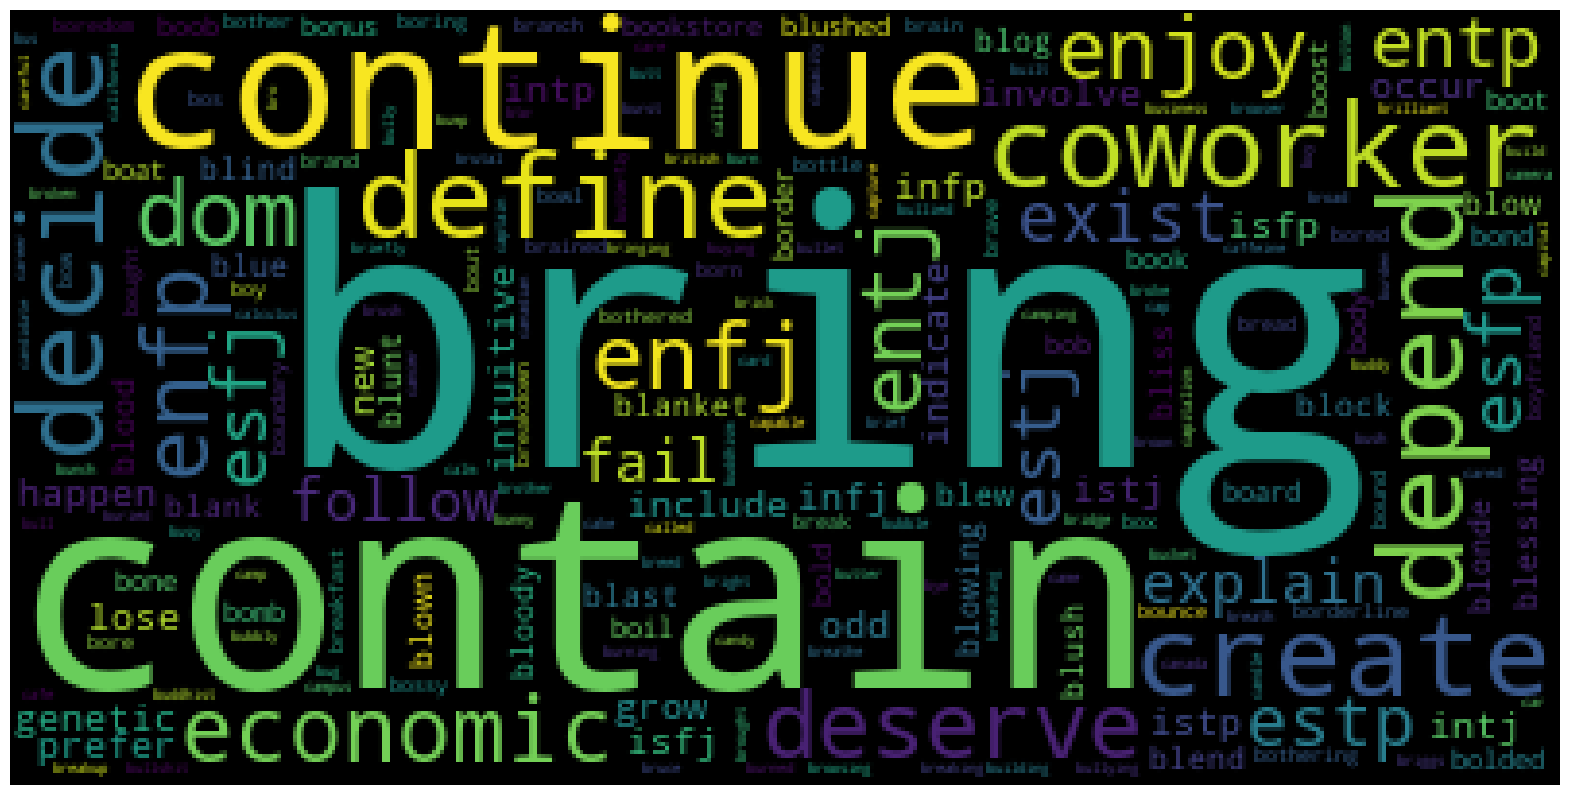

In [13]:
feature_names=vectorizer.get_feature_names_out()
wc=WordCloud(max_words=400)
wc.generate(' '.join(word for word in feature_names[500:3500] ))
plt.figure(figsize=(20,15))
plt.axis('off')
plt.imshow(wc)



### Label encoding

Label encoding is used to convert the categorical variable (in this case the target variable) into numerical values so that it can be used as input to the models.

In [14]:
# Encoding

target_encoder=LabelEncoder()
train_target=target_encoder.fit_transform(train_data.type)
test_target=target_encoder.fit_transform(test_data.type)


## Model Selection
---

In [15]:
models_accuracy={}



In [16]:
# Logistic Regression

model_log=LogisticRegression(max_iter=3000,C=0.5,n_jobs=-1)
model_log.fit(train_post,train_target)

print('train classification report \n ',classification_report(train_target,model_log.predict(train_post),target_names=target_encoder.inverse_transform([i for i in range(16)])))
print('test classification report \n',classification_report(test_target,model_log.predict(test_post),target_names=target_encoder.inverse_transform([i for i in range(16)])))

models_accuracy['logistic regression']=accuracy_score(test_target,model_log.predict(test_post))



train classification report 
                precision    recall  f1-score   support

        ENFJ       0.86      0.16      0.27       152
        ENFP       0.80      0.65      0.72       540
        ENTJ       0.93      0.29      0.44       185
        ENTP       0.82      0.66      0.73       548
        ESFJ       0.00      0.00      0.00        33
        ESFP       0.00      0.00      0.00        38
        ESTJ       0.00      0.00      0.00        31
        ESTP       1.00      0.04      0.08        71
        INFJ       0.74      0.83      0.78      1176
        INFP       0.66      0.93      0.77      1466
        INTJ       0.73      0.81      0.77       873
        INTP       0.69      0.87      0.77      1043
        ISFJ       0.89      0.24      0.38       133
        ISFP       0.86      0.25      0.39       217
        ISTJ       0.86      0.27      0.41       164
        ISTP       0.86      0.51      0.64       270

    accuracy                           0.72      

In [17]:
# Linear Support Vector Classifier

model_linear_svc=LinearSVC(C=0.1)
model_linear_svc.fit(train_post,train_target)

print('train classification report \n ',classification_report(train_target,model_linear_svc.predict(train_post),target_names=target_encoder.inverse_transform([i for i in range(16)])))
print('test classification report \n',classification_report(test_target,model_linear_svc.predict(test_post),target_names=target_encoder.inverse_transform([i for i in range(16)])))

models_accuracy['Linear Support Vector classifier']=accuracy_score(test_target,model_linear_svc.predict(test_post))



train classification report 
                precision    recall  f1-score   support

        ENFJ       0.88      0.45      0.60       152
        ENFP       0.85      0.76      0.80       540
        ENTJ       0.92      0.64      0.76       185
        ENTP       0.84      0.82      0.83       548
        ESFJ       0.91      0.30      0.45        33
        ESFP       1.00      0.13      0.23        38
        ESTJ       1.00      0.26      0.41        31
        ESTP       0.92      0.48      0.63        71
        INFJ       0.82      0.86      0.84      1176
        INFP       0.77      0.93      0.84      1466
        INTJ       0.83      0.86      0.84       873
        INTP       0.81      0.90      0.85      1043
        ISFJ       0.92      0.67      0.77       133
        ISFP       0.89      0.58      0.70       217
        ISTJ       0.88      0.66      0.76       164
        ISTP       0.90      0.82      0.86       270

    accuracy                           0.82      

In [18]:
# Support Vector Classifier

model_svc=SVC()
model_svc.fit(train_post,train_target)

print('train classification report \n ',classification_report(train_target,model_svc.predict(train_post),target_names=target_encoder.inverse_transform([i for i in range(16)])))
print('test classification report \n ',classification_report(test_target,model_svc.predict(test_post),target_names=target_encoder.inverse_transform([i for i in range(16)])))

models_accuracy['Support Vector classifier']=accuracy_score(test_target,model_svc.predict(test_post))



train classification report 
                precision    recall  f1-score   support

        ENFJ       0.97      0.86      0.91       152
        ENFP       0.96      0.95      0.95       540
        ENTJ       0.98      0.90      0.94       185
        ENTP       0.95      0.96      0.95       548
        ESFJ       1.00      0.58      0.73        33
        ESFP       1.00      0.37      0.54        38
        ESTJ       1.00      0.52      0.68        31
        ESTP       1.00      0.82      0.90        71
        INFJ       0.95      0.97      0.96      1176
        INFP       0.93      0.98      0.95      1466
        INTJ       0.96      0.96      0.96       873
        INTP       0.94      0.97      0.96      1043
        ISFJ       1.00      0.89      0.94       133
        ISFP       0.97      0.89      0.93       217
        ISTJ       0.94      0.92      0.93       164
        ISTP       0.97      0.94      0.95       270

    accuracy                           0.95      

In [19]:
# Multinomial Naive Bayes

model_multinomial_nb=MultinomialNB()
model_multinomial_nb.fit(train_post,train_target)

print('train classification report \n ',classification_report(train_target,model_multinomial_nb.predict(train_post),target_names=target_encoder.inverse_transform([i for i in range(16)])))
print('test classification report \n ',classification_report(test_target,model_multinomial_nb.predict(test_post),target_names=target_encoder.inverse_transform([i for i in range(16)])))

models_accuracy['Multinomial Naive Bayes']=accuracy_score(test_target,model_multinomial_nb.predict(test_post))



train classification report 
                precision    recall  f1-score   support

        ENFJ       0.00      0.00      0.00       152
        ENFP       0.90      0.02      0.03       540
        ENTJ       0.00      0.00      0.00       185
        ENTP       0.91      0.06      0.11       548
        ESFJ       0.00      0.00      0.00        33
        ESFP       0.00      0.00      0.00        38
        ESTJ       0.00      0.00      0.00        31
        ESTP       0.00      0.00      0.00        71
        INFJ       0.52      0.62      0.57      1176
        INFP       0.35      0.94      0.51      1466
        INTJ       0.78      0.42      0.55       873
        INTP       0.58      0.63      0.61      1043
        ISFJ       0.00      0.00      0.00       133
        ISFP       0.00      0.00      0.00       217
        ISTJ       0.00      0.00      0.00       164
        ISTP       1.00      0.00      0.01       270

    accuracy                           0.46      

In [20]:
# Decision Tree Classifier

model_tree=DecisionTreeClassifier(max_depth=14)
model_tree.fit(train_post,train_target)

print('train classification report \n ',classification_report(train_target,model_tree.predict(train_post),target_names=target_encoder.inverse_transform([i for i in range(16)])))
print('test classification report \n ',classification_report(test_target,model_tree.predict(test_post),target_names=target_encoder.inverse_transform([i for i in range(16)])))

models_accuracy['Decision Tree classifier']=accuracy_score(test_target,model_tree.predict(test_post))



train classification report 
                precision    recall  f1-score   support

        ENFJ       0.58      0.55      0.56       152
        ENFP       0.90      0.81      0.85       540
        ENTJ       0.84      0.68      0.75       185
        ENTP       0.92      0.78      0.84       548
        ESFJ       0.83      0.30      0.44        33
        ESFP       0.71      0.32      0.44        38
        ESTJ       0.80      0.26      0.39        31
        ESTP       0.88      0.42      0.57        71
        INFJ       0.86      0.84      0.85      1176
        INFP       0.63      0.94      0.75      1466
        INTJ       0.91      0.79      0.85       873
        INTP       0.85      0.81      0.83      1043
        ISFJ       0.96      0.59      0.73       133
        ISFP       0.96      0.59      0.73       217
        ISTJ       0.89      0.57      0.69       164
        ISTP       0.99      0.70      0.82       270

    accuracy                           0.80      

In [21]:
# Random Forest Classifier

model_forest=RandomForestClassifier(max_depth=10)
model_forest.fit(train_post,train_target)


print('train classification report \n ',classification_report(train_target,model_forest.predict(train_post),target_names=target_encoder.inverse_transform([i for i in range(16)])))
print('test classification report \n ',classification_report(test_target,model_forest.predict(test_post),target_names=target_encoder.inverse_transform([i for i in range(16)])))

models_accuracy['Random Forest Classifier']=accuracy_score(test_target,model_forest.predict(test_post))



train classification report 
                precision    recall  f1-score   support

        ENFJ       1.00      0.07      0.12       152
        ENFP       0.98      0.40      0.57       540
        ENTJ       1.00      0.06      0.12       185
        ENTP       1.00      0.47      0.64       548
        ESFJ       0.00      0.00      0.00        33
        ESFP       0.00      0.00      0.00        38
        ESTJ       0.00      0.00      0.00        31
        ESTP       0.00      0.00      0.00        71
        INFJ       0.81      0.82      0.82      1176
        INFP       0.45      0.99      0.62      1466
        INTJ       0.88      0.72      0.79       873
        INTP       0.76      0.87      0.81      1043
        ISFJ       1.00      0.05      0.10       133
        ISFP       1.00      0.08      0.15       217
        ISTJ       1.00      0.03      0.06       164
        ISTP       1.00      0.21      0.35       270

    accuracy                           0.65      

In [22]:
# XGBoost Classifier

# model_xgb=XGBClassifier(gpu_id=0,tree_method='gpu_hist',max_depth=5,n_estimators=50,learning_rate=0.1)
model_xgb=XGBClassifier(max_depth=5,n_estimators=50,learning_rate=0.1)
model_xgb.fit(train_post,train_target)

print('train classification report \n ',classification_report(train_target,model_xgb.predict(train_post),target_names=target_encoder.inverse_transform([i for i in range(16)])))
print('test classification report \n ',classification_report(test_target,model_xgb.predict(test_post),target_names=target_encoder.inverse_transform([i for i in range(16)])))

models_accuracy['XGBoost Classifier']=accuracy_score(test_target,model_xgb.predict(test_post))



[16:51:08] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
train classification report 
                precision    recall  f1-score   support

        ENFJ       0.99      0.95      0.97       152
        ENFP       0.95      0.91      0.93       540
        ENTJ       0.99      0.93      0.96       185
        ENTP       0.95      0.91      0.93       548
        ESFJ       1.00      0.94      0.97        33
        ESFP       1.00      0.95      0.97        38
        ESTJ       1.00      0.84      0.91        31
        ESTP       1.00      0.97      0.99        71
        INFJ       0.91      0.91      0.91      1176
        INFP       0.90      0.95      0.92      1466
        INTJ       0.93      0.93      0.93   

In [23]:
# CatBoost Classifier

model_cat=CatBoostClassifier(loss_function='MultiClass',eval_metric='MultiClass',task_type='GPU',verbose=False)
model_cat.fit(train_post,train_target)

print('train classification report \n ',classification_report(train_target,model_cat.predict(train_post),target_names=target_encoder.inverse_transform([i for i in range(16)])))
print('test classification report \n ',classification_report(test_target,model_cat.predict(test_post),target_names=target_encoder.inverse_transform([i for i in range(16)])))

models_accuracy['CatBoost Classifier']=accuracy_score(test_target,model_cat.predict(test_post))



train classification report 
                precision    recall  f1-score   support

        ENFJ       0.87      0.60      0.71       152
        ENFP       0.83      0.78      0.80       540
        ENTJ       0.88      0.65      0.75       185
        ENTP       0.82      0.81      0.81       548
        ESFJ       0.94      0.48      0.64        33
        ESFP       1.00      0.26      0.42        38
        ESTJ       1.00      0.39      0.56        31
        ESTP       0.96      0.65      0.77        71
        INFJ       0.81      0.85      0.83      1176
        INFP       0.80      0.90      0.85      1466
        INTJ       0.82      0.83      0.82       873
        INTP       0.79      0.88      0.83      1043
        ISFJ       0.90      0.70      0.79       133
        ISFP       0.85      0.66      0.74       217
        ISTJ       0.91      0.73      0.81       164
        ISTP       0.90      0.80      0.85       270

    accuracy                           0.82      

In [24]:
models_accuracy

models_accuracy.keys()

accuracy=pd.DataFrame(models_accuracy.items(),columns=['Models','Test accuracy'])

accuracy.sort_values(by='Test accuracy',ascending=False,ignore_index=True).style.background_gradient(cmap='Blues')



,Models,Test accuracy
0,XGBoost Classifier,0.674928
1,CatBoost Classifier,0.667435
2,Linear Support Vector classifier,0.664553
3,Support Vector classifier,0.647262
4,logistic regression,0.629971
5,Decision Tree classifier,0.509510
6,Random Forest Classifier,0.465130
7,Multinomial Naive Bayes,0.378098


## Export
---

In [27]:
import joblib
import os

def export_models(models=[], path='../models/', active=False):
    """
    Export trained models
    - models : List of tuples (model, 'name')
    - path : directory where to save files
    - active : defines if the function should export models when called
    """
    if active :
        if not os.path.exists(path):
            os.makedirs(path)
        for model in models:
            file_path = path + model[1] + '.joblib'
            joblib.dump(model[0], file_path)
            print(f'Model saved to {file_path}')



models_list = [
    (model_log, "model_log"), # Logistic Regression
    (model_linear_svc, "model_linear_svc"), # Linear Support Vector Classifier
    (model_svc, "model_svc"), # Support Vector Classifier
    (model_multinomial_nb, "model_multinomial_nb"), # Multinomial Naive Bayes
    (model_tree, "model_tree"), # Decision Tree Classifier
    (model_forest, "model_forest"), # Random Forest Classifier
    (model_xgb, "model_xgb"), # XGBoost Classifier
    (model_cat, "model_cat"), # CatBoost Classifier
]

models_path = '../models/'

export_models(models=models_list, path=models_path, active=True)




Model saved to ./models/model_log.joblib
Model saved to ./models/model_linear_svc.joblib
Model saved to ./models/model_svc.joblib
Model saved to ./models/model_multinomial_nb.joblib
Model saved to ./models/model_tree.joblib
Model saved to ./models/model_forest.joblib
Model saved to ./models/model_xgb.joblib
Model saved to ./models/model_cat.joblib


In [28]:
# accuracy.to_pickle('../models_accuracy.pkl')
accuracy.to_csv('../results/models_accuracy.csv', index=False)



## Test prediction
---

In [35]:
# Test

# Import the necessary libraries
import pandas as pd
import joblib

# Load the trained model
model = joblib.load('../models/model_svc.joblib')

# Create a new dataframe with the text data you want to test
new_data = pd.DataFrame({'posts':['World is a beautiful place full of amazing people and opportunities !']})

# Clean and preprocess the text data
new_data.posts,_ = clear_text(new_data)
new_post = vectorizer.transform(new_data.posts).toarray()

# Use the model to predict the personality type
predictions = model.predict(new_post)
print(target_encoder.inverse_transform(predictions))

100%|██████████| 1/1 [00:00<?, ?it/s]

['INFP']


In [37]:
# Test

# Import the necessary libraries
import pandas as pd
import joblib

# Create a new dataframe with the text data you want to test
new_data = pd.DataFrame({'posts':['World is a beautiful place full of amazing people and opportunities !']})


def test_models(data, vectorizer, target_encoder):
    models = [
        joblib.load('../models/model_log.joblib'),
        joblib.load('../models/model_linear_svc.joblib'),
        joblib.load('../models/model_svc.joblib'),
        joblib.load('../models/model_multinomial_nb.joblib'),
        joblib.load('../models/model_tree.joblib'),
        joblib.load('../models/model_forest.joblib'),
        joblib.load('../models/model_xgb.joblib'),
        joblib.load('../models/model_cat.joblib')
    ]
    model_names = [
        'Logistic Regression',
        'Linear SVC',
        'SVC',
        'Multinomial NB',
        'Decision Tree',
        'Random Forest',
        'XGBoost',
        'CatBoost'
    ]
    cleaned_data,_ = clear_text(data)
    vectorized_data = vectorizer.transform(cleaned_data).toarray()
    for i, model in enumerate(models):
        predictions = model.predict(vectorized_data)
        print(f'{model_names[i]}: {target_encoder.inverse_transform(predictions)}')


test_models(new_data, vectorizer, target_encoder)

100%|██████████| 1/1 [00:00<00:00, 997.22it/s]

Logistic Regression: ['INFP']
Linear SVC: ['INFP']
SVC: ['INFP']
Multinomial NB: ['INFP']
Decision Tree: ['INFP']
Random Forest: ['INFP']
XGBoost: ['INTP']
CatBoost: ['INTP']
